# Building a Spam Filter with Naive Bayes

## Introduction

In this project we will buil a spam filter for SMS messages using Naive Bayes alorithm.
To train the algorithm, we will use a dataset of 5,572 SMS messages that are classified by humans as spam or ham. The dataset is located in [The UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection)

## Aim
The aim of this project is to create a spam filter that clssifies new messages with an accuracy greater than 80%, this means we expect that more than 80% of the new messages will be classified correctly as spam or no spam. 

In [1]:
import pandas as pd

In [2]:
sms_spam = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['Label', 'SMS'])

print(sms_spam.shape)

(5572, 2)


## Exploring data

In [3]:
sms_spam.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
#there are 5572 rows and 2 columns
sms_spam.shape

(5572, 2)

In [5]:
#the dataset contains 86.6% no spam and 13.4% spam
sms_spam['Label'].value_counts(normalize=True)*100

ham     86.593683
spam    13.406317
Name: Label, dtype: float64

## Training and Test

First we need to test spam filter, for this we will split the dataset into two categories:

* training set: train the computer how to classify messages.
* test set: test how good the spam filter classifying new messages.

we will kepp 80% of the datasetfor training and 20% for testing. As we know there are 5572 messages:

* training set will have 4458 messages, about 80% of the dataset.
* test set will have 1114 messages, 20% of the dataset.

1114 messages in our test set are already classified by a human. when the spam filter is ready, we are going to take these messages as new and have the filter classify them. When we have the results we will be able to compare the algorithm classification with that done by a human and we will see how good the spam filter really is


In [6]:
#randomize the entire dataset
data_randomized=sms_spam.sample(frac=1,random_state=1)

training_test_index = round(len(data_randomized) * 0.8)

# Training/Test split
training_set = data_randomized[:training_test_index].reset_index(drop=True)
test_set = data_randomized[training_test_index:].reset_index(drop=True)

print(training_set.shape)
print(test_set.shape)

(4458, 2)
(1114, 2)


In [7]:
training_set.shape

(4458, 2)

In [8]:
test_set.shape

(1114, 2)

In [9]:
#finding percentage of spam and ham in training set
training_set['Label'].value_counts(normalize=True)*100

ham     86.54105
spam    13.45895
Name: Label, dtype: float64

In [10]:
#finding percentage of spam and ham in test set
test_set['Label'].value_counts(normalize=True)*100

ham     86.804309
spam    13.195691
Name: Label, dtype: float64

## Data cleaning

The next step is to use the training set to teach the algorithm to classify new messages.
In order to use our Naive Bayes algorithm we will make the calssification based on the results, for this we need to calculate number of times each word appears in each SMS in a new schema

![image](https://camo.githubusercontent.com/27a4a0a699bd8f0713d73347abe2929c267a03d5/68747470733a2f2f64712d636f6e74656e742e73332e616d617a6f6e6177732e636f6d2f3433332f637067705f646174617365745f332e706e67)

We will remove all the punctuation from the SMS column and special characters

In [11]:
#before cleaning
training_set.head()

,Label,SMS
0,ham,"Yep, by the pretty sculpture"
1,ham,"Yes, princess. Are you going to make me moan?"
2,ham,Welp apparently he retired
3,ham,Havent.
4,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [12]:
# After cleaning
training_set['SMS'] = training_set['SMS'].str.replace('\W', ' ')
training_set['SMS'] = training_set['SMS'].str.lower()
training_set.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [13]:
training_set['SMS'] = training_set['SMS'].str.split()

vocabulary = []
for sms in training_set['SMS']:
    for word in sms:
        vocabulary.append(word)
        
vocabulary = list(set(vocabulary))

In [14]:
len(vocabulary)

7783

## The final training set

we are now going to use the vocabulary we just created to make the data transformation we want

In [15]:
word_counts_per_sms = {unique_word: [0] * len(training_set['SMS']) for unique_word in vocabulary}

for index, sms in enumerate(training_set['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] += 1

In [16]:
word_counts = pd.DataFrame(word_counts_per_sms)
word_counts.head()

,apologize,c52,parent,complementary,motivating,shipping,140ppm,dating,edition,acl03530150pm,dokey,persian,headache,barkleys,ip4,easiest,academic,doctor,summers,hurried,hun,inst,scenario,affairs,nearly,sorry,walk,tau,qi,utter,major,credits,150p,okors,brain,idea,fetching,downstem,uncle,praveesh,...,uks,usf,february,easter,start,clean,wrecked,youwanna,await,begin,renting,bro,2wks,workin,ipads,likely,28th,tiger,friendships,reg,massive,belly,ringtoneking,breathe1,makes,soundtrack,gloucesterroad,successfully,motive,sucker,helpline,friday,complain,tones2u,waves,troubleshooting,hunt,purple,visitors,clubmoby
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [17]:
training_set_clean = pd.concat([training_set, word_counts], axis=1)
training_set_clean.head()

,Label,SMS,apologize,c52,parent,complementary,motivating,shipping,140ppm,dating,edition,acl03530150pm,dokey,persian,headache,barkleys,ip4,easiest,academic,doctor,summers,hurried,hun,inst,scenario,affairs,nearly,sorry,walk,tau,qi,utter,major,credits,150p,okors,brain,idea,fetching,downstem,...,uks,usf,february,easter,start,clean,wrecked,youwanna,await,begin,renting,bro,2wks,workin,ipads,likely,28th,tiger,friendships,reg,massive,belly,ringtoneking,breathe1,makes,soundtrack,gloucesterroad,successfully,motive,sucker,helpline,friday,complain,tones2u,waves,troubleshooting,hunt,purple,visitors,clubmoby
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Calculating constants




Naive Bayes algorithm will need to know the probability values of the two equations below to be able to classify new messages

$$
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam)
$$$$
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
$$

Also to calculate  P(wi|Spam) and P(wi|Ham) inside the formulas above, we'll need to use these equations:

$$
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}}
$$$$
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
$$

Some of the terms in the four equations above will have the same value for every new message.
first calculate

* P(Spam) and P(Ham)
* NSpam, NHam, NVocabulary

we also Laplace smoothing and set $\alpha = 1$

In [18]:
# Isolating spam and ham messages first
spam_messages = training_set_clean[training_set_clean['Label'] == 'spam']
ham_messages = training_set_clean[training_set_clean['Label'] == 'ham']

# P(Spam) and P(Ham)
p_spam = len(spam_messages) / len(training_set_clean)
p_ham = len(ham_messages) / len(training_set_clean)

# N_Spam
n_words_per_spam_message = spam_messages['SMS'].apply(len)
n_spam = n_words_per_spam_message.sum()

# N_Ham
n_words_per_ham_message = ham_messages['SMS'].apply(len)
n_ham = n_words_per_ham_message.sum()

# N_Vocabulary
n_vocabulary = len(vocabulary)

# Laplace smoothing
alpha = 1


## Calculating parameters

Once we have calculated constants we need to move on with calculating the parameters image.png and image.png. Each parameter will be a conditional probability value associated with each word in the vocabulary

the parameters are calculated using the next formulas:

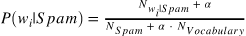

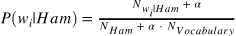

In [19]:
# Initiate parameters
parameters_spam = {unique_word:0 for unique_word in vocabulary}
parameters_ham = {unique_word:0 for unique_word in vocabulary}

# Calculate parameters
for word in vocabulary:
    n_word_given_spam = spam_messages[word].sum()   # spam_messages already defined in a cell above
    p_word_given_spam = (n_word_given_spam + alpha) / (n_spam + alpha*n_vocabulary)
    parameters_spam[word] = p_word_given_spam
    
    n_word_given_ham = ham_messages[word].sum()   # ham_messages already defined in a cell above
    p_word_given_ham = (n_word_given_ham + alpha) / (n_ham + alpha*n_vocabulary)
    parameters_ham[word] = p_word_given_ham

## Creating spam filter

the spam filter will be a function that:

* takes in as input a new message 'w1,w2...'
* calculates P(spam|w1,w2...,wn) and P(Ham|w1,w2,...,wn), and:
*compares the values of P(Spam|w1, w2, ..., wn) and P(Ham|w1, w2, ..., wn), and:
 * If P(Ham|w1, w2, ..., wn) > P(Spam|w1, w2, ..., wn), then the message is classified as ham.
 * If P(Ham|w1, w2, ..., wn) < P(Spam|w1, w2, ..., wn), then the message is classified as spam.
 * If P(Ham|w1, w2, ..., wn) = P(Spam|w1, w2, ..., wn), then the algorithm may request human help.


In [20]:
import re

def classify(message):
    '''
    message: a string
    '''
    
    message = re.sub('\W', ' ', message)
    message = message.lower().split()
    
    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]
            
        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]
            
    print('P(Spam|message):', p_spam_given_message)
    print('P(Ham|message):', p_ham_given_message)
    
    if p_ham_given_message > p_spam_given_message:
        print('Label: Ham')
    elif p_ham_given_message < p_spam_given_message:
        print('Label: Spam')
    else:
        print('Equal proabilities, have a human classify this!')

In [21]:
classify('WINNER!! This is the secret code to unlock the money: C3421.')

P(Spam|message): 1.3481290211300841e-25
P(Ham|message): 1.9368049028589875e-27
Label: Spam


In [22]:
classify("Sounds good, Tom, then see u there")

P(Spam|message): 2.4372375665888117e-25
P(Ham|message): 3.687530435009238e-21
Label: Ham


## Function accuracy

We now we will determine how well the spam filter is on test set of 1,114 messages.
the algorithm will output a classification label for every messages in test set, which will be able to compare with te actual label (given by human).
first, we will change classify() function to return the labels instead of printing them.

In [23]:
def classify_test_set(message):

    message = re.sub('\W', ' ', message)
    message = message.lower()
    message = message.split()

    p_spam_given_message = p_spam
    p_ham_given_message = p_ham

    for word in message:
        if word in parameters_spam:
            p_spam_given_message *= parameters_spam[word]

        if word in parameters_ham:
            p_ham_given_message *= parameters_ham[word]

    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

In [24]:
#the function now returns labels, we can create a new column in our test set
test_set['predicted'] = test_set['SMS'].apply(classify_test_set)
test_set.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


we can compare the predicted values with the actual values to measure how good our spam filter is with classifying messages.

Accuracy
=
number of correctly classified messages
/
total number of classified messages


In [25]:
correct=0
total=test_set.shape[0]

for row in test_set.iterrows():
    row = row[1]
    if row['Label'] == row['predicted']:
        correct += 1
        
print('Correct:', correct)
print('Incorrect:', total - correct)
print('Accuracy:', correct/total)


Correct: 1100
Incorrect: 14
Accuracy: 0.9874326750448833


The accuracy is close to 98.74% which is a high accuracy, it means spam filter looked at 1,114 messages that have been trained and classified 1,100 correctly